# A simulation of neutron irradiation of a cobalt-59 film

This simulation uses the same geometry and materials as the basic petal simulation, but places a film of cobalt directly in front of the neutron beam.

In [375]:
# Imports
import openmc
import numpy as np
import matplotlib.pyplot as plt

## Create materials

In [376]:
# Define above materials
li7 = openmc.Material(name='Lithium')
li7.add_element('Li', 1.0) #changed to be natural Li
li7.set_density('g/cm3', 0.534)

cu = openmc.Material(name='Copper')
cu.add_element('Cu', 1.0)
cu.set_density('g/cm3', 8.96)

ti = openmc.Material(name='Titanium')
ti.add_element('Ti', 1.0)
ti.set_density('g/cm3', 4.506)

h2o = openmc.Material(name='Water')
h2o.add_nuclide('H1', 2.0)
h2o.add_nuclide('O16', 1.0)
h2o.add_s_alpha_beta('c_H_in_H2O')
h2o.set_density('g/cm3', 1.0)

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 2.1)

air = openmc.Material(name='Air')
air.add_element('N', 0.78)
air.add_element('O', 0.21)
air.add_element('Ar', 0.01)
air.set_density('g/cm3', 1.225E-3)

co59 = openmc.Material(name='Cobalt')
co59.add_nuclide('Co59', 1.0)
co59.set_density('g/cm3', 8.86)

beo = openmc.Material(name='BeO')
beo.add_element('Be',1.0)
beo.add_element('O',1.0)
beo.set_density('g/cm3', 3.02)

# Export to XML
materials = openmc.Materials([li7, cu, ti, h2o, graphite, air, co59,beo])
materials.export_to_xml()

## Define geometry
First, define measurements.

In [377]:
# Define material thicknesses (cm)
li_thickness = 0.02
cu_thickness = 0.15 #Works out as half-thickness here?
vacuum_thickness_2 = 0.48
water_thickness = 0.03
graphite_thickness = 0.7
vacuum_thickness_1 = 1.5
ti_thickness = 0.6
total_thickness = 4.5

# Foil properties (cm)
foil_width = 0.1
foil_thickness = 0.1#0.1#0.025  
foil_pos = -42
air_gap = 0.1

# Define wheel radius (cm)
wh_r = 50
# Petal angle (deg)
pet_ang = 30

Now, define surfaces.

In [378]:
# Cylinder to define target wheel
cylinder = openmc.Cylinder(r=wh_r, dx=0.0, dy=0.0, dz=1.0)

# Layers of target
li_start = openmc.ZPlane(z0=-li_thickness/2)
li_end = openmc.ZPlane(z0=li_thickness/2)
cu_1_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness)
water_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness)
cu_2_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness)
vac_1_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1)
graph_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness)
vac_2_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2)
ti_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2 + ti_thickness)

# Foil details (note: foil is placed flush with titanium, so use ti_end as start surface)
foil_start = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2 + ti_thickness + air_gap)
foil_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2 + ti_thickness + air_gap + foil_thickness)
foil_left = openmc.XPlane(x0=-foil_width/2)
foil_right = openmc.XPlane(x0=foil_width/2)
foil_bottom = openmc.YPlane(y0=foil_pos-foil_width/2)
foil_top = openmc.YPlane(y0=foil_pos+foil_width/2)

# Define surfaces for room geometry
back_wall = openmc.ZPlane(z0=-50, boundary_type='vacuum')
front_wall = openmc.ZPlane(z0=250, boundary_type='vacuum')
left_wall = openmc.XPlane(x0=-150, boundary_type='vacuum')
right_wall = openmc.XPlane(x0=150, boundary_type='vacuum')
floor = openmc.YPlane(y0=-100, boundary_type='vacuum')
ceiling = openmc.YPlane(y0=100,boundary_type='vacuum')

## Define cells

In [379]:
# Target cells
li_cell = openmc.Cell(name='Li_cell', fill=li7, region = - cylinder & + li_start & - li_end)
cu_cell_1 = openmc.Cell(name='Cu_cell_1', fill=cu, region = -cylinder & + li_end & - cu_1_end)
water_cell = openmc.Cell(name='water_cell', fill=h2o, region = -cylinder & + cu_1_end & - water_end)
cu_cell_2 = openmc.Cell(name='Cu_cell_2',fill=cu, region = -cylinder & + water_end & - cu_2_end)
vac_cell_1 = openmc.Cell(name='vac_cell_1',fill=None, region = -cylinder & + cu_2_end & - vac_1_end)
graphite_cell = openmc.Cell(name='graphite_cell', fill=graphite, region = -cylinder & + vac_1_end & -graph_end)
vac_cell_2 = openmc.Cell(name='vac_cell_2', fill=None, region = -cylinder & + graph_end & - vac_2_end)
ti_cell = openmc.Cell(name='ti_cell', fill=ti, region = -cylinder & + vac_2_end & -ti_end)

# Foil cell
foil_region = +foil_left & -foil_right & +foil_bottom & -foil_top & +foil_start & -foil_end
foil_cell = openmc.Cell(name='foil_cell', fill=beo, region = foil_region)

wheel_region = -cylinder & -li_start & +ti_end

# Define room cell
room_cell = openmc.Cell(name='room_cell', fill=air, region = +back_wall & -front_wall & +left_wall & -right_wall & +floor & -ceiling & ~wheel_region & ~foil_region)

# Add all cells to geometry 
geometry = openmc.Geometry([room_cell, li_cell, cu_cell_1, cu_cell_2, water_cell, vac_cell_1,  vac_cell_2, graphite_cell, ti_cell, foil_cell])
geometry.export_to_xml()

## Plot geometry as check

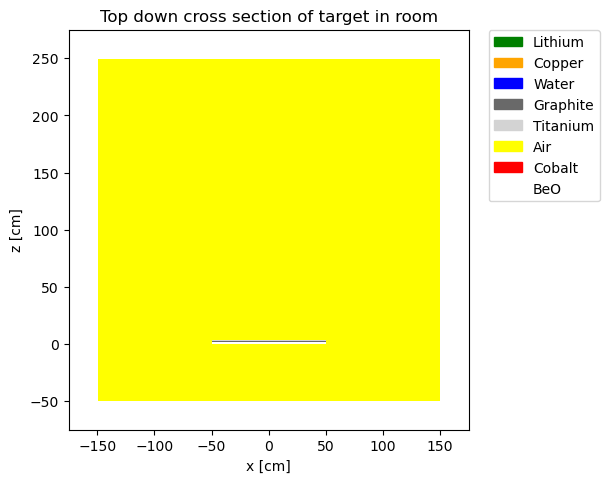

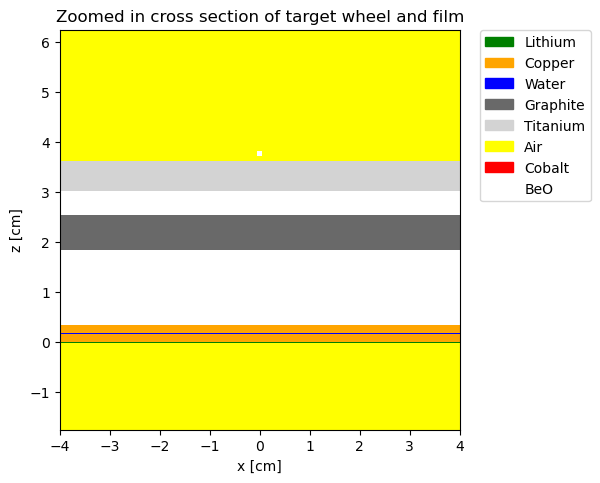

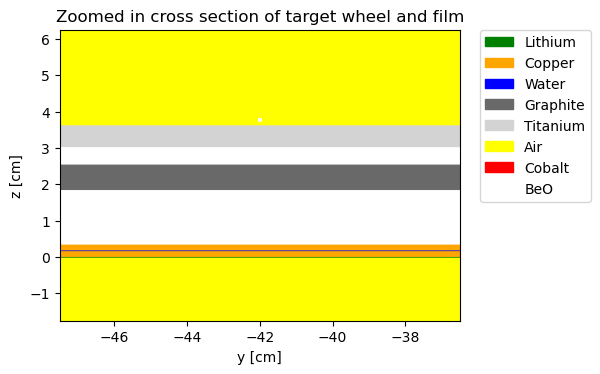

In [380]:
%matplotlib inline
# Zoomed out geometry of whole target rooom
geometry.plot((0,0,100), width=(350, 350), pixels=(400,400), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'yellow', co59: 'red', beo: 'white'},
                    legend=True, outline=False)
plt.title('Top down cross section of target in room')
plt.show()

# Zoomed in geometry of target wheel and film
geometry.plot((0,-42,4.5/2), width=(8, 8), pixels=(400,400), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'yellow', co59: 'red', beo: 'white'},
                    legend=True, outline=False)
plt.title('Zoomed in cross section of target wheel and film')
plt.show()

# Zoomed in geometry of target wheel and film
geometry.plot((0,-42,4.5/2), width=(11, 8), pixels=(400,400), basis='yz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'yellow', co59: 'red', beo: 'white'},
                    legend=True, outline=False)
plt.title('Zoomed in cross section of target wheel and film')
plt.show()

## Set up simulation

In [381]:
# Define source
Ep = '1.885'
comp_source = openmc.CompiledSource(f'../build/libsource.so', Ep)

# Set up simulation
settings = openmc.Settings()
settings.source = comp_source
settings.particles = 1_000_000
settings.batches = 100
settings.run_mode = 'fixed source'
settings.max_tracks = 10_000
settings.export_to_xml()

In [382]:
# Define filters
foil_cell_filter = openmc.CellFilter([foil_cell])
foil_surface_filter = openmc.SurfaceFilter(foil_end)
energy_filter= openmc.EnergyFilter(np.linspace(0, 1e6, ))

# Define current tally
flux_tally = openmc.Tally(name='Flux_tally')
flux_tally.scores = ['flux']
flux_tally.filters = [foil_cell_filter]

# Define (n,gamma) tally
n_gamma_tally = openmc.Tally(name='N_gamma_tally')
n_gamma_tally.scores = ['(n,gamma)']
n_gamma_tally.filters = [foil_cell_filter]

#Define new energy filter
Etarget_tally = openmc.Tally(name='Etarget_tally')
Etarget_tally.scores = ['flux']
foil_cell_filter_E = openmc.EnergyFilter(np.linspace(0,1e6,1000))
Etarget_tally.filters = [foil_cell_filter_E,foil_cell_filter]

# Export tallies
tallies = openmc.Tallies([flux_tally, n_gamma_tally, Etarget_tally])
tallies.export_to_xml()

## Run simulation

In [ ]:
openmc.run(tracks=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Get tallies from statepoint file

In [ ]:
from matplotlib import colormaps

# Define energy colourmap
# Plot tracks
tracks = openmc.Tracks(f'tracks.h5')

energies = []
for t in tracks:
    start = t.particle_tracks[0].states['E'][0]#First step
    #print(start)
    energies.append((start))

#energies = energies.sort()
print(len(energies),"events")
E_array = np.array(energies)
E_max = np.max(E_array)
plt.hist(E_array*1E-6,bins=200)
plt.show()

In [ ]:
# %matplotlib qt
geometry.plot((0,-42,100), width=(350, 350), pixels=(5000,5000), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'white', co59: 'red'},
                    legend=False, outline=False)

for t in tracks[:100]:

    E = t.particle_tracks[0].states['E'][0]
    c = E/E_max
    cells = t.particle_tracks[0].states['cell_id']
    cell_track = ([i for i in cells if i == foil_cell.id])
    #print(cells)
    c_map = plt.cm.plasma(c)
    #print(c_map)
    x = []
    y = []
    z = []
    start = t.particle_tracks[0].states['r']
    if len(cell_track) > 0: #if track goes through the foil cell ever
        for v in start:
            x.append(v[0])
            y.append(v[1])
            z.append(v[2])
    
        plt.plot(x[:], z[:], color=c_map)

#plt.scatter(x, z)
#plt.xlim(-5,5)
#plt.ylim(-2,5)
plt.title('Projection of neutron tracks in x-z plane.')
plt.show()

In [ ]:
# Zoomed in geometry of target wheel and film

downsample = 10
for t in tracks[::downsample]:

    E = t.particle_tracks[0].states['E'][0]
    cells = t.particle_tracks[0].states['cell_id']
    cell_track = ([i for i in cells if i == foil_cell.id])
    c = E/E_max
    #print(c)
    c_map = plt.cm.plasma(c)
    #print(c_map)
    x = []
    y = []
    z = []
    start = t.particle_tracks[0].states['r']
    if len(cell_track) >= 0: 
        for v in start: 
            #print(v)
            x.append(v[0])
            y.append(v[1])
            z.append(v[2])

        plt.plot(x[:], z[:], color=c_map)
        #plt.scatter(x[0], z[0], color=c_map)

plt.title('Zoomed in cross section of target wheel and film')
#plt.xlim(-5,5)
#plt.ylim(-0.5, 5)
plt.show()
geometry.plot((0,-42,4.5/2), width=(11, 8), pixels=(400,400), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'yellow', co59: 'red'},
                    legend=True, outline=False)

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

for t in tracks[:100]:
    E = t.particle_tracks[0].states['E'][0]
    c = E/E_max
    #print(c)
    c_map = plt.cm.plasma(c)
    x = []
    y = []
    z = []
    start = t.particle_tracks[0].states['r']
    for v in start: #all tracks
        x.append(v[0])
        y.append(v[1])
        z.append(v[2])
    plt.plot(z, x, y, color=c_map)

#plt.scatter(x, z)
plt.title('3D plot of neutron tracks in target room.', fontsize=18)
ax.set_xlabel('z (cm)')
ax.set_ylabel('x (cm)')
ax.set_zlabel('y (cm)')
# ax.set_xlim(4.5,5)
# ax.set_ylim(-10,10)
# ax.set_zlim(-50,-30)

plt.savefig("3Dtracks.png")
plt.show()

In [ ]:
with openmc.StatePoint('statepoint.10.h5') as sp:
    #print(sp.tallies)
    #flux_output = sp.get_tally(flux_tally.name)
    #n_gamma_output = sp.get_tally(n_gamma_tally.name)
    df1 = sp.tallies[n_gamma_tally.id].get_pandas_dataframe()
    df2 = sp.tallies[flux_tally.id].get_pandas_dataframe()
    df3 = sp.tallies[Etarget_tally.id].get_pandas_dataframe()

print(df1.head(10))
#print(df2.head(10))
#print()
print(df3)

plt.errorbar(1e-6*df3['energy low [eV]'],df3['mean'],xerr=np.zeros_like(df3['mean']),yerr=df3['std. dev.'],ls='none',capsize=5)
plt.xlim([0,0.2])
plt.ylim([0,max(df3['mean'])])
plt.show()

print(f"Total neutrons in target: {np.sum(df3['mean']):.2e} of {settings.particles*settings.batches:.2e} total")